##PINN:

In [1]:
import time
import math
import torch
import numpy as np
from problems import sixth_order
from pinn import PINN, make_points
from plots_and_stats import plot_errors, plot_comparison
np.random.seed(1234)

a1 = 1.000, a2 = -1.000, a3 = -2.800, a4 = -0.300, a5 = -0.600, a6 = 0.100,
 b1 = 6.000, b2 = -1.525, b3 = 0.113


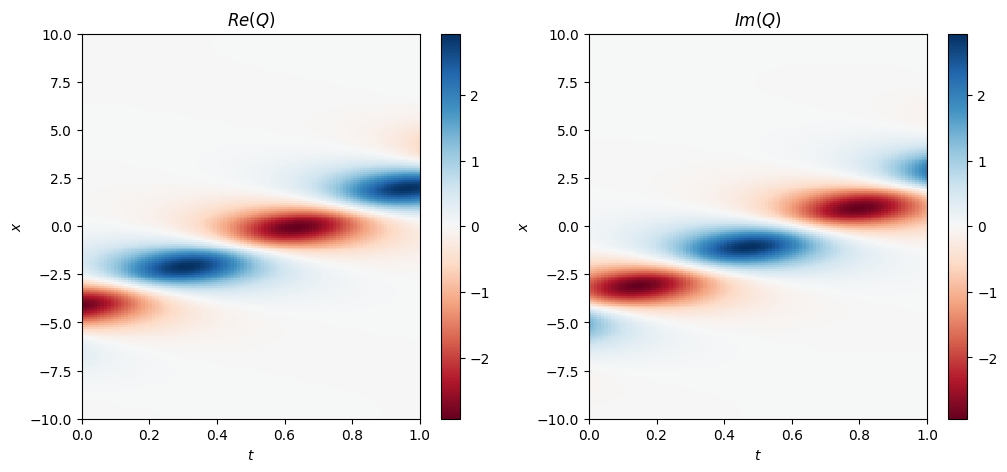

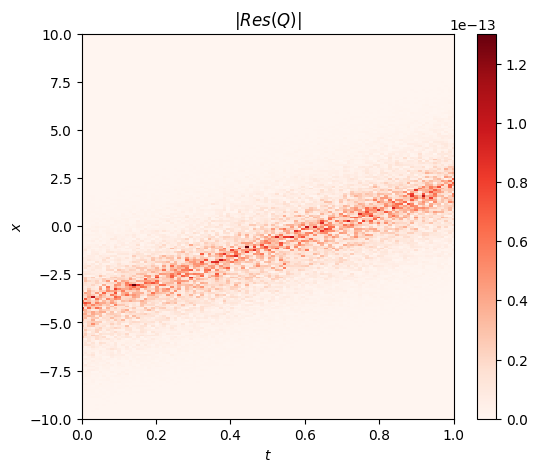

In [2]:
#domain setting
x_0=-10.
x_1=10.
t_0=0.
t_1=1.
#problem setting
a1 = 1
a2 = -1
a4 = -0.3
a6 = 0.1
b1 = 6
khi = 1
a_param = 0.5
x0_param = 4
theta0 = math.pi/3
problem = sixth_order(x_0, x_1, t_0, t_1, a1, a2, a4, a6, b1, khi, a_param, x0_param, theta0)
#info about the problem
problem.show_params()
problem.show_solution(x_resolution=200, t_resolution=100, show_residual=True)

In [3]:
#data for metrics evaluation
x_parts=200
t_parts=100
x=np.linspace(x_0,x_1,x_parts)
t=np.linspace(t_0,t_1,t_parts)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #test input for PINN
Q_truth=problem.q(X,T) #ground truth

/tmp/ipykernel_5096/2340480616.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'tuned_model(2).pth', map_location=device)


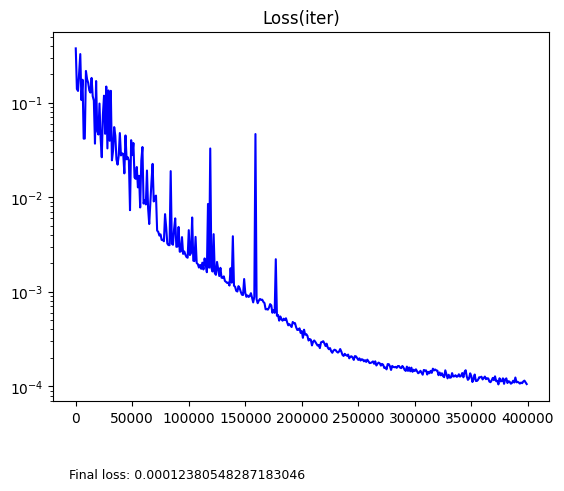

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = torch.load(f'model(0).pth', map_location=device)
model.train_hist(logscale=True, step=1000)
model.adam.param_groups[0]['lr'] = 0.0001
model.adam_steps = 200000 #amount of steps to be done

In [5]:
%%time
model.train()

Training continued from Iter=400000 with second points generation method, none loss balancing and causal loss
200000 steps of ADAM:
Iter 410000, Loss: 1.070e-04, Loss_i: 2.22e-05, Loss_b: 1.76e-05, Loss_f: 1.04e-03
Iter 420000, Loss: 1.108e-04, Loss_i: 2.06e-05, Loss_b: 1.77e-05, Loss_f: 1.11e-03
Iter 430000, Loss: 1.054e-04, Loss_i: 2.04e-05, Loss_b: 1.64e-05, Loss_f: 1.04e-03
Iter 440000, Loss: 9.574e-05, Loss_i: 1.81e-05, Loss_b: 1.81e-05, Loss_f: 9.50e-04
Iter 450000, Loss: 9.280e-05, Loss_i: 1.80e-05, Loss_b: 1.57e-05, Loss_f: 9.18e-04
Iter 460000, Loss: 9.016e-05, Loss_i: 1.74e-05, Loss_b: 1.55e-05, Loss_f: 8.92e-04
Iter 470000, Loss: 8.759e-05, Loss_i: 1.67e-05, Loss_b: 1.62e-05, Loss_f: 8.68e-04
Iter 480000, Loss: 8.813e-05, Loss_i: 1.61e-05, Loss_b: 1.57e-05, Loss_f: 8.81e-04
Iter 490000, Loss: 8.297e-05, Loss_i: 1.55e-05, Loss_b: 1.45e-05, Loss_f: 8.26e-04
Iter 500000, Loss: 8.316e-05, Loss_i: 1.55e-05, Loss_b: 1.59e-05, Loss_f: 8.27e-04
Iter 510000, Loss: 8.188e-05, Loss_i: 

In [6]:
torch.save(model, f'model(1).pth')

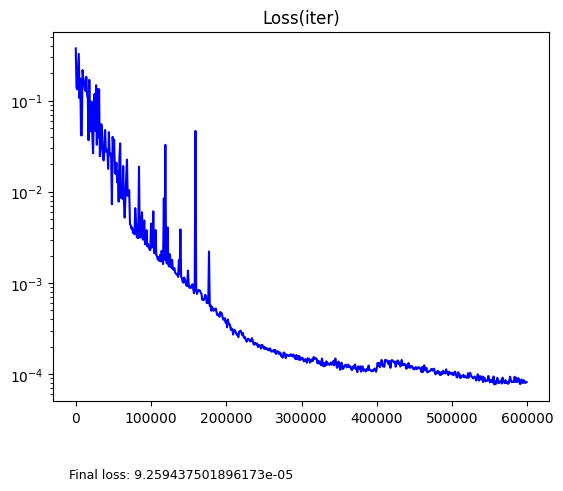

In [7]:
model.train_hist(logscale=True, step=1000)

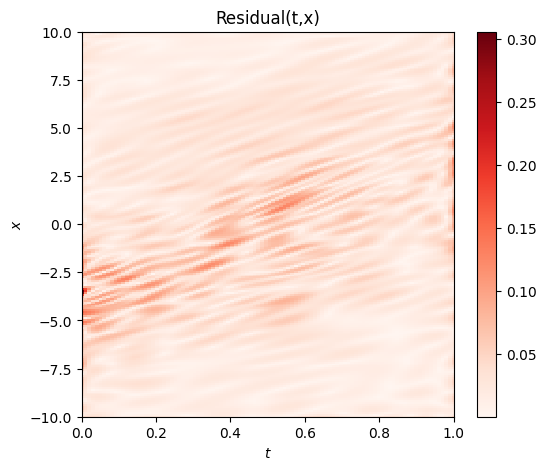

In [8]:
model.plot_residual(X, T)

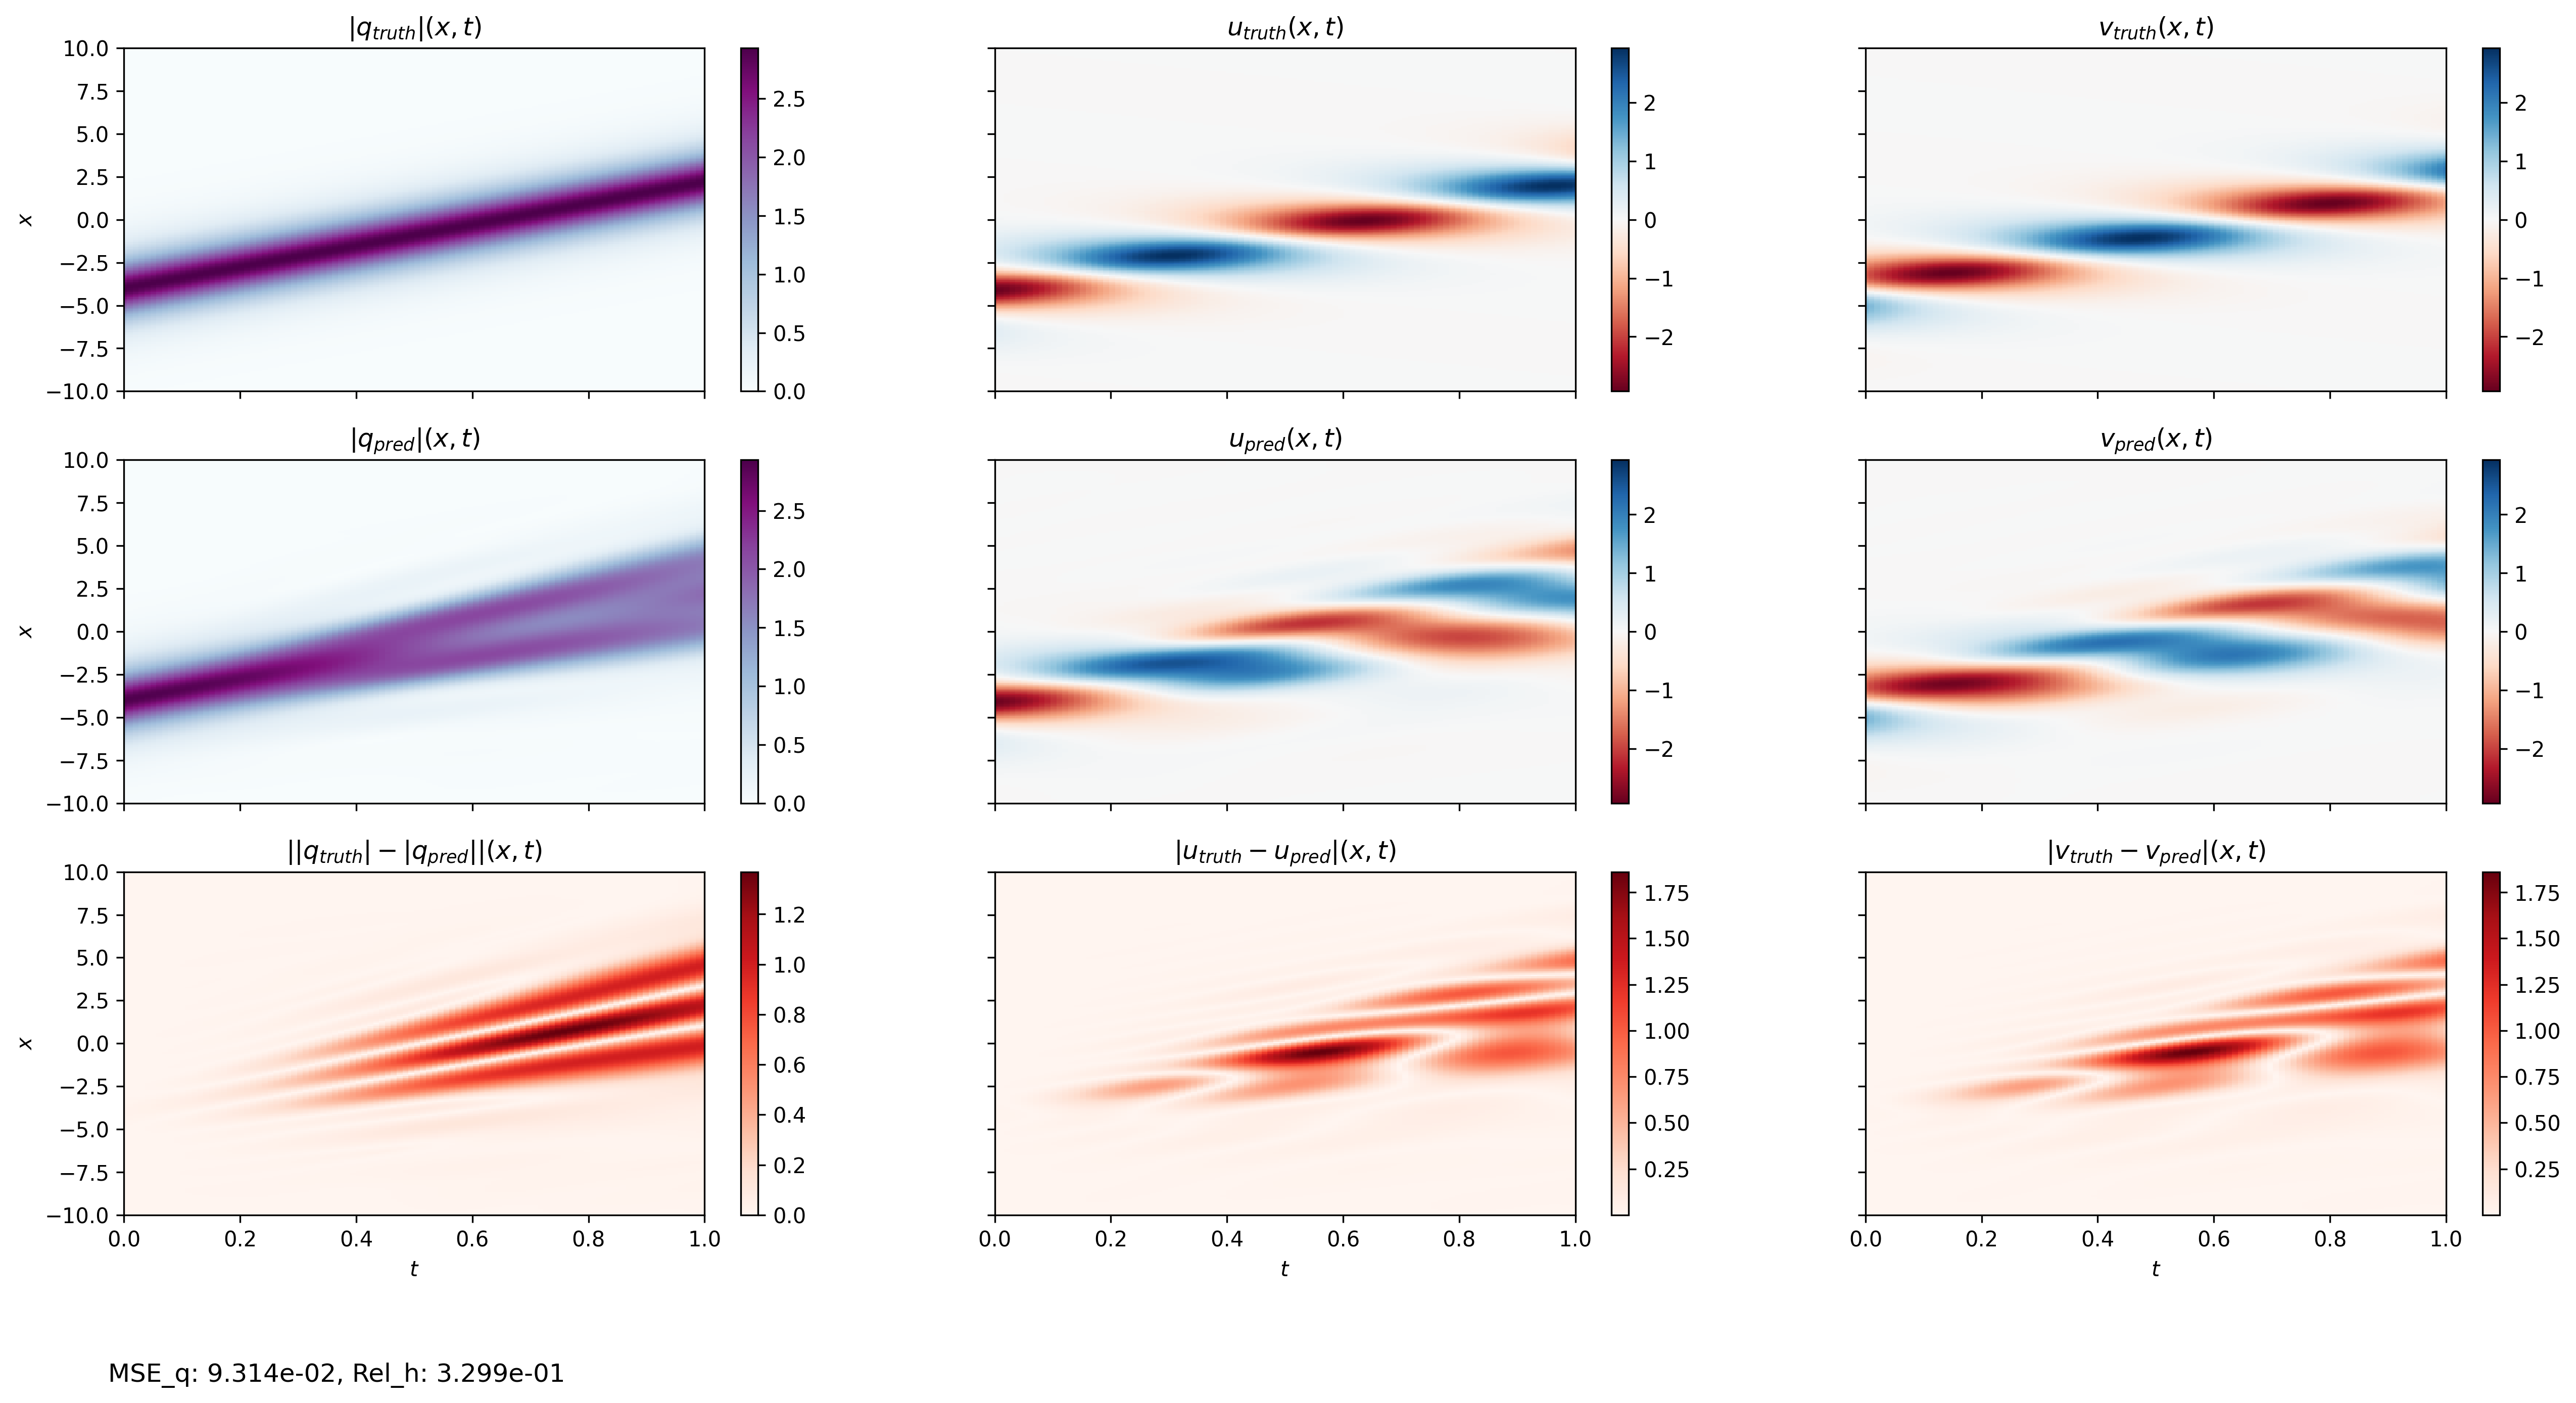

{'MSE_q': 0.09314155713726356, 'Rel_h': 0.3299218555784164}

In [9]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
Q_pred=u_pred.reshape((t_parts, x_parts)) + 1j*v_pred.reshape((t_parts, x_parts))
plot_comparison(X, T, Q_pred, Q_truth, savefig=False)

Dimensionality by x: 200, by t: 100


{'Lw1_per_max': 1.31088592590241,
 'Lw1_per_mean': 1.1923222042617483,
 'Lw2_per_max': 1.4430377077649108,
 'Lw2_per_mean': 1.3032145371800028,
 'Rel_h': 0.3299218555784164}

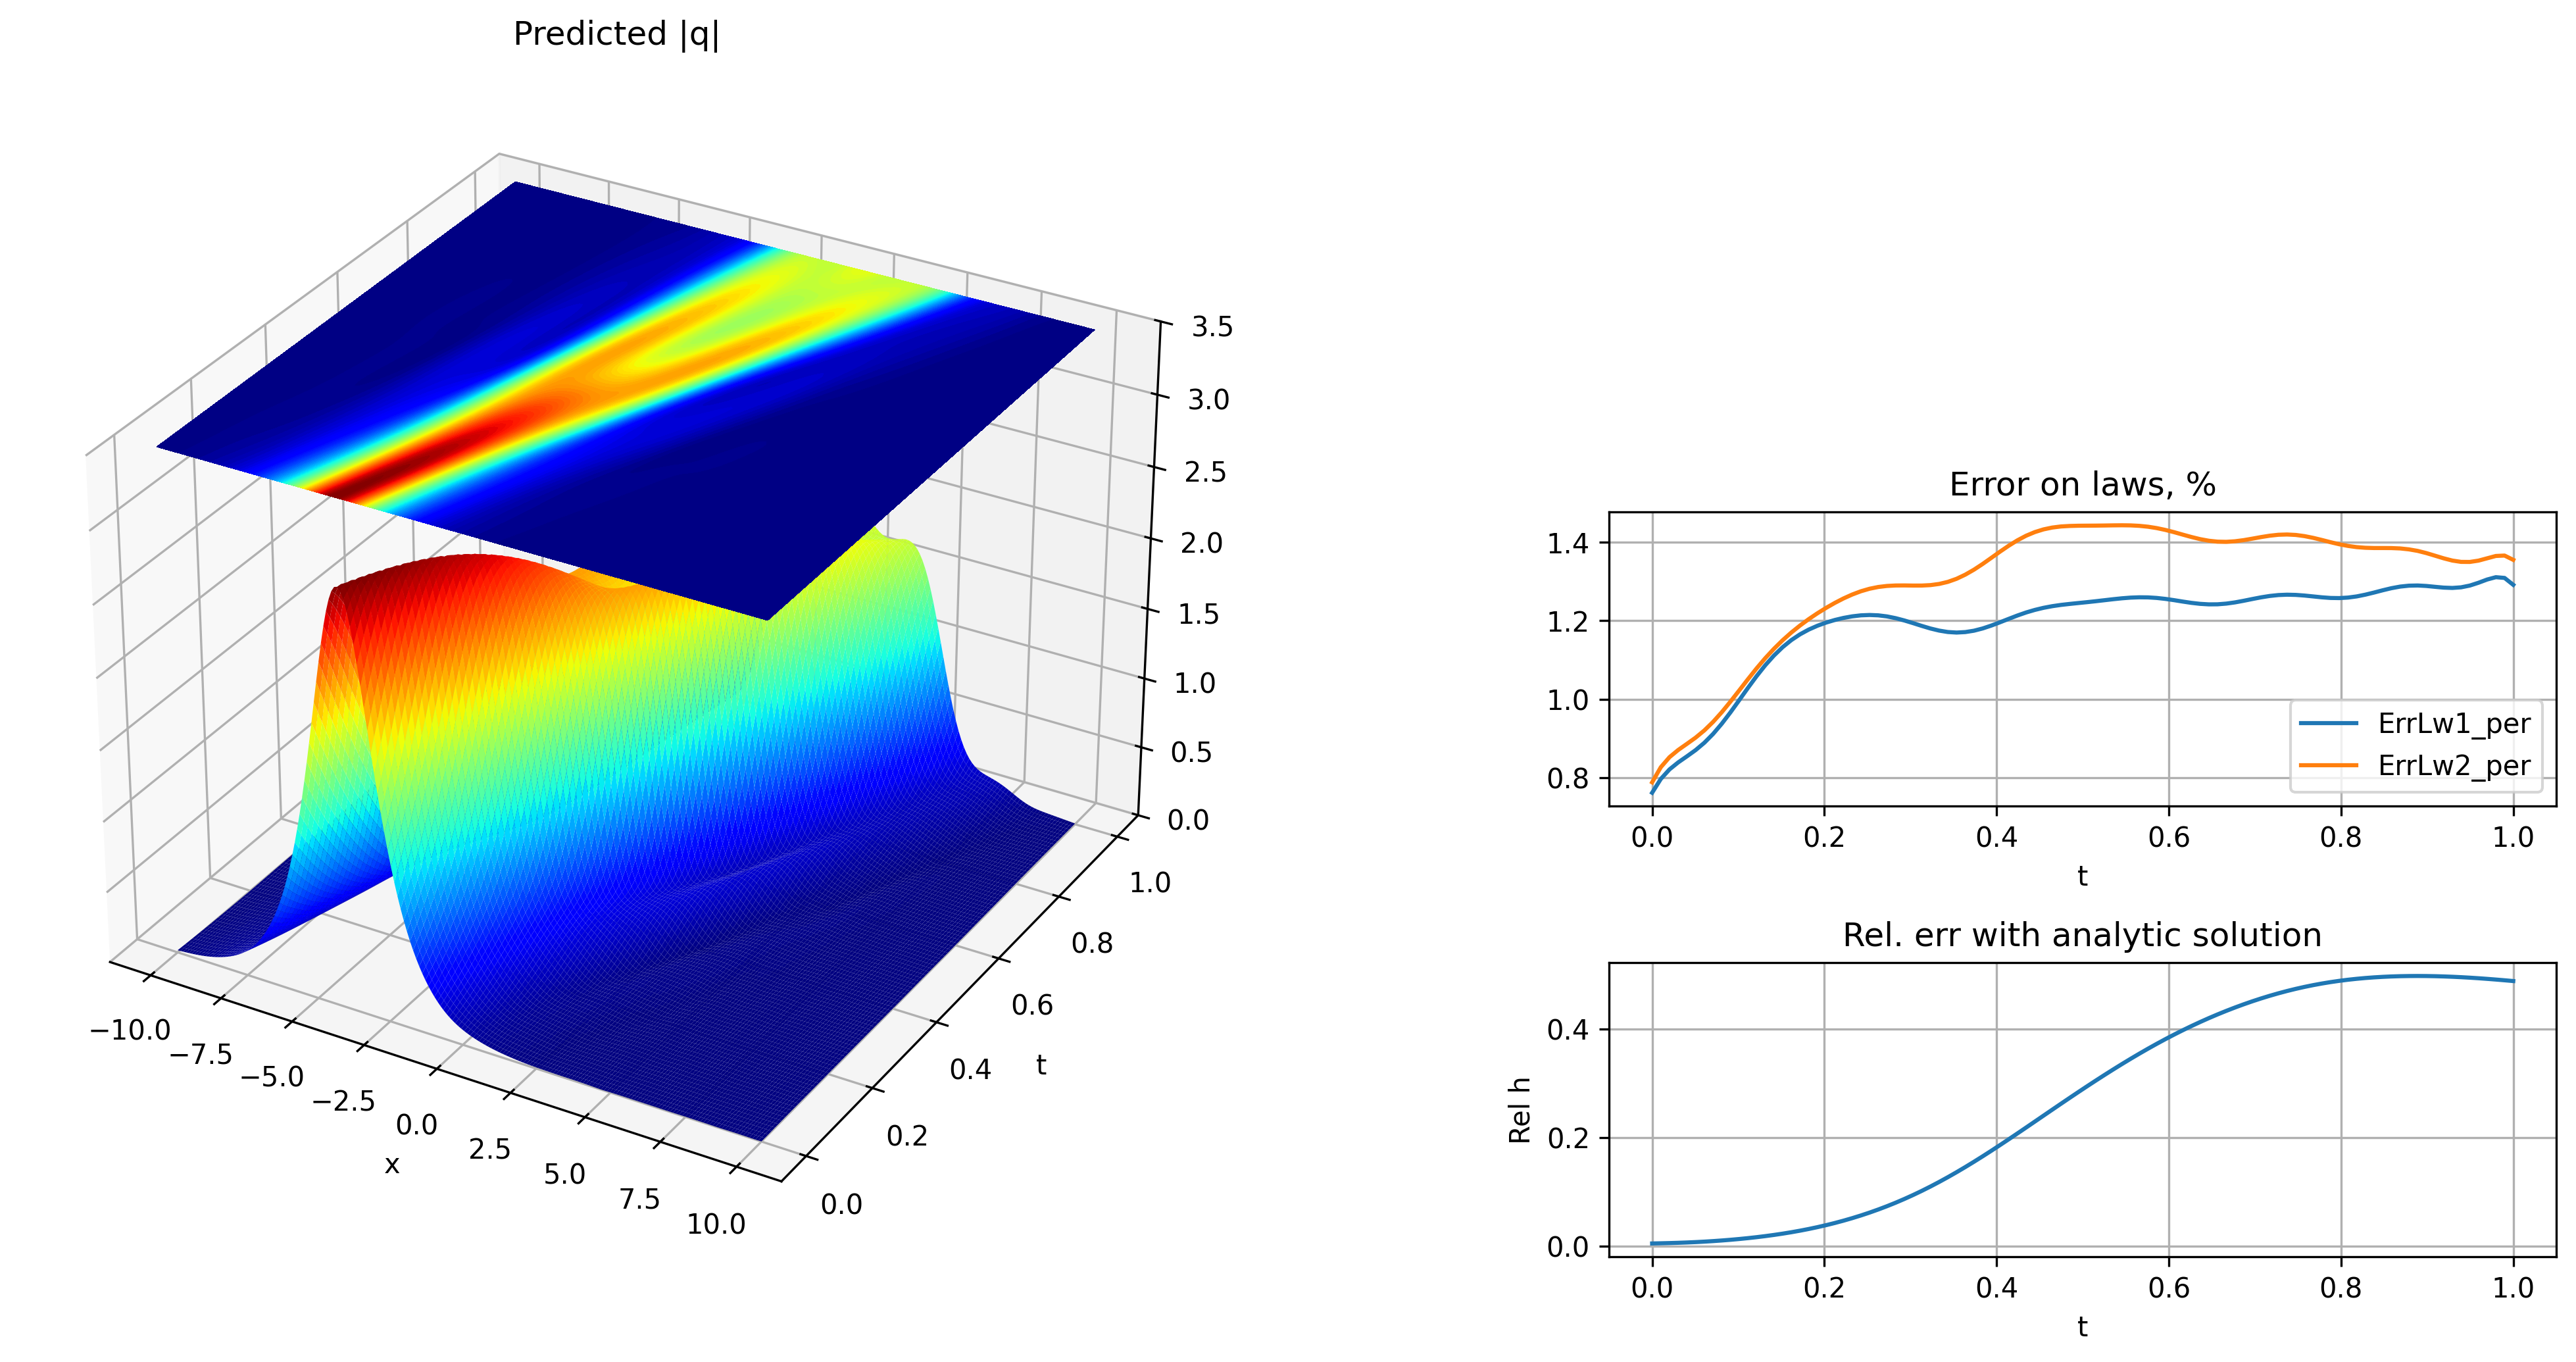

In [10]:
plot_errors(X, T, Q_pred, Q_truth, savefig=False, savetable=False)